## LSTM AUTOENCODER

In [1]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 1000
data = process(filename,rows)
n_rows = data.shape[0] 
n_features = data.shape[1]
print(data.shape)

(989, 64)


In [2]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array


In [3]:
from overlapping_window import overlap_window

time_steps = 40
a = np.r_[0:n_rows]

X_train_samples = overlap_window(time_steps,20,a)
X_train = data[X_train_samples,:]
X_train = np.squeeze(X_train)
print(X_train.shape)

X_reversed = np.flip(X_train,1)

(48, 40, 64)


In [12]:
print(X_reversed[0,:,0])
print(X_train[0,:,0])

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0
 0 0 0]
[0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0]


In [8]:
 print(X_train.shape)

(48, 40, 64)


In [4]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]


lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)

encoderLSTM = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)

# define Encoder
EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)
lstm1 = encoderLSTM(dropout)
lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm1)
encoder_states = [state_h, state_c]

# define Decoder
lstm3 =  LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm2,initial_state=encoder_states)
lstm4 = LSTM(128,return_sequences=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(dense2)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()

Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 40, 256)      16640       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 40, 256)      0           dense[0][0]                      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 40, 128)      197120      dropout[0][0]                    
_____________________________________________________________________________________

In [4]:
def model_builder(hp):
   # do the lstm layers need to have the same number of units? will do that
   # do the two dense layers need to have the same number of units?
    n_samples = X_train.shape[0]
    time_steps = X_train.shape[1]
    n_features = X_train.shape[2]


    uniformInitializerMin = hp.Float('uniformMin', min_value=-1, max_value=0,step=0.01)
    uniformInitializerMax = hp.Float('uniformMax', min_value=0, max_value=1,step=0.01)
    lstm_initializer = tf.keras.initializers.RandomUniform(minval=uniformInitializerMin, maxval=uniformInitializerMax) 
    
    lstm_units = hp.Int('lstmUnits', min_value=1, max_value=500, step=10)

    # define Encoder
    EncoderInputs = Input(shape=(time_steps,n_features))
    
    dense_units = hp.Int('denseUnits', min_value=10, max_value=5000, step=50)
    dense1 =Dense(units=dense_units, activation='tanh')(EncoderInputs)
    
    dropoutP = hp.Float('dropout',min_value=0.0, max_value=0.95, step=0.05)
    dropout = Dropout(dropoutP)(dense1) 
  
    lstm1,state_h,state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout)
    lstm2, state_h,state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout,initial_state=[state_h,state_c])

    #decoder
    lstm3, state_h, state_c = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)(dropout,initial_state=[state_h,state_c])
    lstm4 = LSTM(units=lstm_units,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_sequences = True)(dropout,initial_state=[state_h,state_c])

    
    output = Dense(n_features,activation= 'sigmoid')(lstm4)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
    EncoderDecoder.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy')#, metrics=[tf.keras.metrics.BinaryCrossentropy()])

    return EncoderDecoder

In [5]:
import kerastuner as kt
tuner = kt.Hyperband(model_builder,
                     overwrite=True,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='C:\ tune',
                     #directory='tuning',
                     project_name='LSTM' 
                     )

es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)
tuner.search(X_train, X_train, epochs=1000, validation_split=0.2, callbacks=[es])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=10)[0]

Trial 18 Complete [00h 01m 17s]
val_loss: 0.40677374601364136

Best val_loss So Far: nan
Total elapsed time: 00h 14m 14s

Search: Running Trial #19

Hyperparameter    |Value             |Best Value So Far 
uniformMin        |-0.74             |-0.9              
uniformMax        |0.16              |0.91              
lstmUnits         |191               |401               
denseUnits        |4110              |4960              
dropout           |0.65              |0.45              
learning_rate     |0.01              |0.001             
tuner/epochs      |4                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |0                 

Epoch 1/4
2/2 [==============================] - 7s 4s/step - loss: 0.7034 - val_loss: 0.6615
Epoch 2/4
2/2 [==============================] - 6s 3s/step - loss: 0.6622 - val_loss: 0.6453
Epoch 3/4


KeyboardInterrupt: 

In [6]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]
import time
train_size = int(np.floor(0.7*n_samples))

model = EncoderDecoder
es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s=time.time()

history = model.fit(X_train[0:train_size,:,:], X_train[0:train_size,:,:], validation_data=(X_train[train_size:,:,:], X_train[train_size:,:,:]), epochs=300, verbose=2, shuffle=False, callbacks = [es])

e=time.time()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

Epoch 1/300


AssertionError: in user code:

    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\ellsan\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\functional.py:517 _run_internal_graph
        assert x_id in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("lambda_1/concat:0", shape=(None, 1920, 64), dtype=float32)


Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40, 64)]     0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40, 256)      16640       input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 40, 256)      0           dense_2[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 128), (None, 197120      dropout_1[0][0]                  
_____________________________________________________________________________________

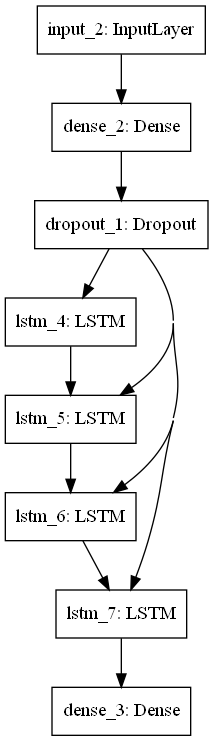

In [6]:
n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]


lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
# do loop? 
# define Encoder
EncoderInputs = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(EncoderInputs)
dropout = Dropout(0.2)(dense1)

encoderLSTM1 = LSTM(128,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)
lstm1, state_h, state_c = encoderLSTM1(dropout)

encoderLSTM2 = LSTM(128,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer, return_state = True)
lstm2, state_h, state_c =encoderLSTM2(dropout,initial_state=[state_h,state_c])

# define Decoder
decoderLSTM1 = LSTM(128,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
lstm3, state_h, state_c =  decoderLSTM1(dropout,initial_state=[state_h, state_c])

decoderLSTM2 =  LSTM(128,return_sequences=True,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
lstm4, state_h, state_c = decoderLSTM2(dropout,initial_state=[state_h,state_c])


#dense2 = Dense(256, activation='sigmoid')(lstm4)
output = Dense(n_features,activation= 'sigmoid')(lstm4)

EncoderDecoder = Model(inputs=EncoderInputs, outputs=output,name="EncoderDecoder")
EncoderDecoder.compile(optimizer='adam', loss='binary_crossentropy')
EncoderDecoder.summary()
plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

In [ ]:
#300 epochs, loss: 0.0594 - val_loss: 0.0723 all connected to dropout, states connected, 256-128*4-256-64
#300 epochs, loss: 0.0544 - val_loss: 0.0674 all connected to dropout, states connected, 256-128*4-64
#300 epochs, loss: 0.0919 - val_loss: 0.1074 all connected to dropout, states connected, 64-128*4-64
#300 epochs, loss: 0.0904 - val_loss: 0.1021 all connected to dropout, states connected, 64-128*2-64
#300 epochs, loss: 0.0598 - val_loss: 0.0726 all connected to dropout, states connected, 256-128*6-64
#300 epochs, loss: 0.2491 - val_loss: 0.2912 connected straight forward, both return states and sequences, 256-128*4-64

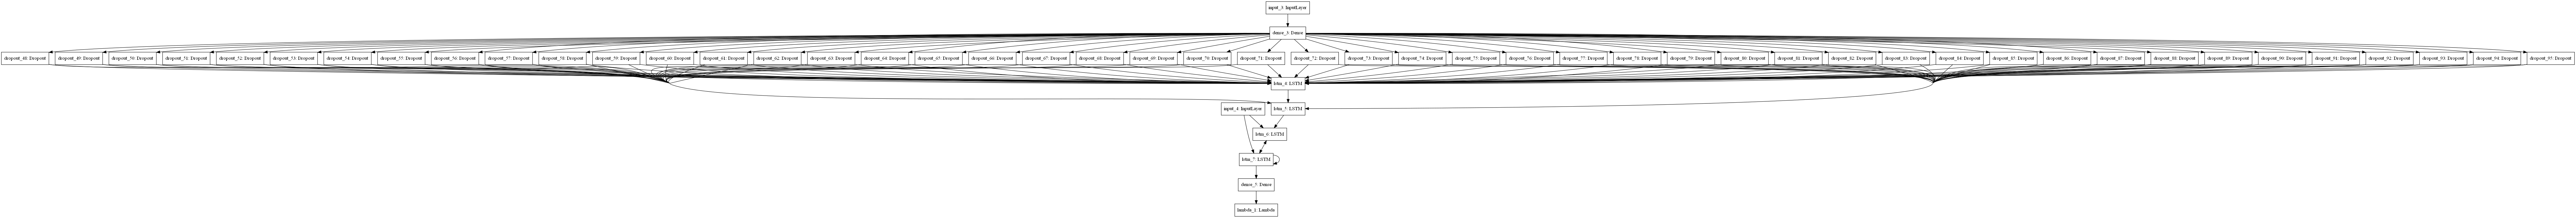

In [5]:
from keras.layers import Lambda
from keras import backend as K

n_samples = X_train.shape[0]
time_steps = X_train.shape[1]
n_features = X_train.shape[2]
lstm_initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)


# define Encoder
encoder_input = Input(shape=(time_steps,n_features))
encoder_dense = Dense(256, activation='tanh')
encoderLSTM1 = LSTM(128,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
encoderLSTM2 =  LSTM(128,return_state=True,kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)


# define Decoder
d_input = Input(shape=(time_steps,128))
decoderLSTM1 = LSTM(128,return_state=True, kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
decoderLSTM2 = LSTM(128,return_sequences=True,return_state=True, kernel_initializer =lstm_initializer, recurrent_initializer=lstm_initializer)
decoder_dense = Dense(256, activation='sigmoid')
output_dense = Dense(n_features,activation= 'sigmoid')

all_outputs = []
decoder_input = d_input
i_vector = np.zeros((time_steps,n_features))#np.zeros((1,time_steps))
for _ in range(n_samples):

    dense1 = encoder_dense(encoder_input)
    dropout = Dropout(0.2)(dense1)
    encoder_lstm1, state_h, state_c = encoderLSTM1(dropout)
    encoder_output, state_h, state_c = encoderLSTM2(dropout,initial_state=[state_h,state_c])

    # Run the decoder on one timestep
    decoder_lstm1, state_h, state_c = decoderLSTM1(decoder_input,initial_state=[state_h,state_c])
    decoder_lstm2, state_h, state_c = decoderLSTM2(decoder_input,initial_state=[state_h,state_c])
    outputs = output_dense(decoder_lstm2)

    # Store the current prediction (we will concatenate all predictions later)
    all_outputs.append(outputs)
    # Reinject the outputs as inputs for the next loop iteration
    decoder_input = decoder_lstm2

   

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define and compile model as previously
model = Model([encoder_input, d_input], decoder_outputs)
model.compile(optimizer='adam', loss='binary_crossentropy')
plot_model(model, to_file='EncoderDecoder.png')